In [ ]:
!pip install -q transformers datasets

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
from tqdm import tqdm
from torchvision import transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image

In [ ]:
import zipfile
import os

# اسم الملف بعد الرفع
zip_path = "Teeth_Dataset.zip"

# فك الضغط
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/Teeth_Dataset")

# التحقق
os.listdir("/content/Teeth_Dataset")


['Teeth_Dataset']

In [ ]:
train_dir = '/content/Teeth_Dataset/Teeth_Dataset/Training'
val_dir   = '/content/Teeth_Dataset/Teeth_Dataset/Testing'
test_dir  = '/content/Teeth_Dataset/Teeth_Dataset/Validation'

In [ ]:
classes = ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
num_classes = len(classes)
img_size = 224
batch_size = 16
num_epochs = 5
learning_rate = 2e-5

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")


/usr/local/lib/python3.12/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [54]:
# Augmentation only for training
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

In [55]:
# Validation and test (no augmentation, just resize + normalize)
val_test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

In [56]:
# Datasets with proper transforms
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=val_test_transform)

In [57]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [58]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=num_classes,
    id2label={i: c for i, c in enumerate(classes)},
    label2id={c: i for i, c in enumerate(classes)}
)

model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [81]:
from torchinfo import summary

summary(model, input_size=(batch_size, 3, 224, 224))

Layer (type:depth-idx)                                       Output Shape              Param #
ViTForImageClassification                                    [16, 7]                   --
├─ViTModel: 1-1                                              [16, 197, 768]            --
│    └─ViTEmbeddings: 2-1                                    [16, 197, 768]            152,064
│    │    └─ViTPatchEmbeddings: 3-1                          [16, 196, 768]            590,592
│    │    └─Dropout: 3-2                                     [16, 197, 768]            --
│    └─ViTEncoder: 2-2                                       [16, 197, 768]            --
│    │    └─ModuleList: 3-3                                  --                        85,054,464
│    └─LayerNorm: 2-3                                        [16, 197, 768]            1,536
├─Linear: 1-2                                                [16, 7]                   5,383
Total params: 85,804,039
Trainable params: 85,804,039
Non-trainable par

In [59]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [60]:
best_val_acc = 0.0
best_model_path = "best_vit_model.pth"
patience = 5
counter = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    total_loss, total_correct = 0, 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images).logits
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        total_correct += (preds == labels).sum().item()
        total_loss += loss.item()

        loop.set_postfix(loss=loss.item())

    train_acc = 100 * total_correct / len(train_dataset)
    avg_loss = total_loss / len(train_loader)

    # ---- Validation ----
    model.eval()
    val_correct, val_loss = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)

            val_correct += (preds == labels).sum().item()
            val_loss += loss.item()

    val_acc = 100 * val_correct / len(val_dataset)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={avg_loss:.4f}, Train Acc={train_acc:.2f}%, "
          f"Val Loss={avg_val_loss:.4f}, Val Acc={val_acc:.2f}%")

    # ---- Checkpoint + Early Stopping ----
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Best model saved with Val Acc: {val_acc:.2f}%")
    else:
        counter += 1
        if counter >= patience:
            print("⏹️ Early stopping triggered")
            break


Epoch 1: Train Loss=1.3849, Train Acc=62.39%, Val Loss=0.8369, Val Acc=89.20%
✅ Best model saved with Val Acc: 89.20%


Epoch 2: Train Loss=0.5493, Train Acc=93.20%, Val Loss=0.3488, Val Acc=97.37%
✅ Best model saved with Val Acc: 97.37%


Epoch 3: Train Loss=0.2542, Train Acc=97.96%, Val Loss=0.1980, Val Acc=98.35%
✅ Best model saved with Val Acc: 98.35%


Epoch 4: Train Loss=0.1516, Train Acc=98.96%, Val Loss=0.1336, Val Acc=99.03%
✅ Best model saved with Val Acc: 99.03%


Epoch 5: Train Loss=0.1105, Train Acc=99.13%, Val Loss=0.0985, Val Acc=99.22%
✅ Best model saved with Val Acc: 99.22%


In [61]:
model.load_state_dict(torch.load(best_model_path))
model.eval()

test_correct, test_loss = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)

        test_correct += (preds == labels).sum().item()
        test_loss += loss.item()

test_acc = 100 * test_correct / len(test_dataset)
print(f"🧪 Test Accuracy = {test_acc:.2f}%")

🧪 Test Accuracy = 99.12%


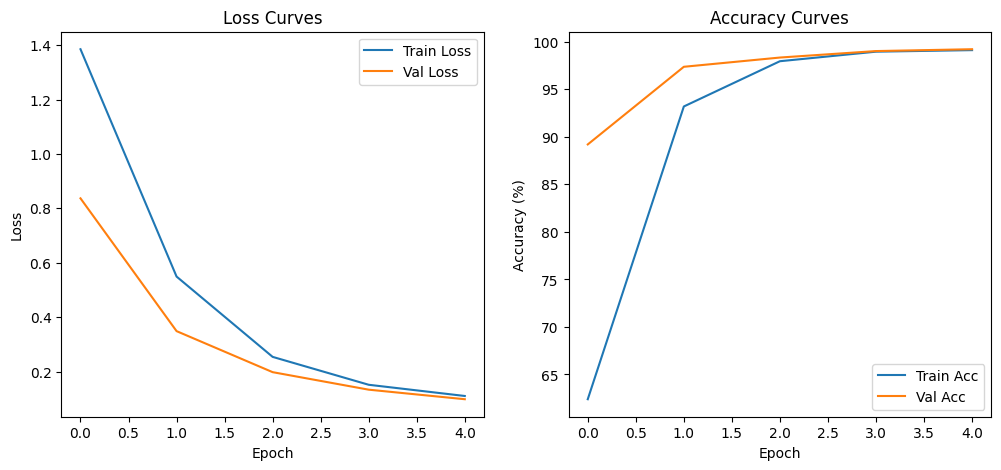

In [62]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")

plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy Curves")

plt.show()

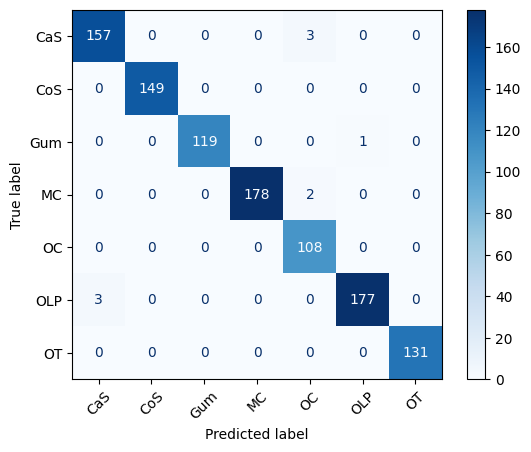

In [65]:
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()


In [72]:
img_path, label = test_dataset.samples[500]
img = Image.open(img_path).convert("RGB")

img_tensor = transform(img).unsqueeze(0).to(device)
with torch.no_grad():
    outputs = model(img_tensor).logits
    probs = torch.nn.functional.softmax(outputs, dim=1)[0]
    pred_class = torch.argmax(probs).item()
    confidence = probs[pred_class].item()

print(f"True Label: {classes[label]}")
print(f"Predicted: {classes[pred_class]} ({confidence*100:.2f}%)")

True Label: MC
Predicted: MC (93.48%)


In [74]:
from google.colab import files
files.download("best_vit_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>